In [1]:
import random
import numpy as np
import pandas as pd
import torch
import config as cfg
from data_loader import get_data_loader
from utility.survival import make_time_bins
from utility.survival import preprocess_data

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Setup precision
dtype = torch.float64
torch.set_default_dtype(dtype)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\au475271\Miniconda3\envs\py39-mensa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
from mensa.model import MENSA
from utility.config import load_config

# Train 4 models with n_dists = 1, 2, 3, 4
trained_models = []
for n_dists in [1, 3, 5, 10]:
    # Reset seeds
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    random.seed(0)

    # Load data
    dl = get_data_loader("proact_me")
    dl = dl.load_data()
    train_dict, valid_dict, test_dict = dl.split_data(train_size=0.7, valid_size=0.1,
                                                      test_size=0.2, random_state=0)
    n_events = dl.n_events

    # Preprocess data
    cat_features = dl.cat_features
    num_features = dl.num_features
    trajectories = dl.trajectories
    event_cols = [f'e{i+1}' for i in range(n_events)]
    time_cols = [f't{i+1}' for i in range(n_events)]
    X_train = pd.DataFrame(train_dict['X'], columns=dl.columns)
    X_valid = pd.DataFrame(valid_dict['X'], columns=dl.columns)
    X_test = pd.DataFrame(test_dict['X'], columns=dl.columns)
    X_train, X_valid, X_test= preprocess_data(X_train, X_valid, X_test, cat_features,
                                            num_features, as_array=True)
    train_dict['X'] = torch.tensor(X_train, device=device, dtype=dtype)
    train_dict['E'] = torch.tensor(train_dict['E'], device=device, dtype=torch.int64)
    train_dict['T'] = torch.tensor(train_dict['T'], device=device, dtype=torch.int64)
    valid_dict['X'] = torch.tensor(X_valid, device=device, dtype=dtype)
    valid_dict['E'] = torch.tensor(valid_dict['E'], device=device, dtype=torch.int64)
    valid_dict['T'] = torch.tensor(valid_dict['T'], device=device, dtype=torch.int64)
    test_dict['X'] = torch.tensor(X_test, device=device, dtype=dtype)
    test_dict['E'] = torch.tensor(test_dict['E'], device=device, dtype=torch.int64)
    test_dict['T'] = torch.tensor(test_dict['T'], device=device, dtype=torch.int64)

    n_samples = train_dict['X'].shape[0]
    n_features = train_dict['X'].shape[1]

    # Make time bins
    time_bins = make_time_bins(train_dict['T'].cpu(), event=None, dtype=dtype).to(device)
    time_bins = torch.cat((torch.tensor([0]).to(device), time_bins))

    config = load_config(cfg.MENSA_CONFIGS_DIR, "proact.yaml")
    n_epochs = config['n_epochs']
    n_dists = n_dists
    lr = config['lr']
    batch_size = config['batch_size']
    layers = config['layers']
    weight_decay = config['weight_decay']
    
    # Clear CUDA cache and garbage collect
    torch.cuda.empty_cache()
    gc.collect()
    
    model = MENSA(n_features, layers=layers, n_events=n_events, 
                  n_dists=n_dists, trajectories=trajectories, device=device)
    model.fit(train_dict, valid_dict, learning_rate=lr, n_epochs=n_epochs,
              weight_decay=weight_decay, patience=10, batch_size=batch_size,
              verbose=False)
    trained_models.append(model)

Early stopping at iteration 109, best valid loss: 12.695311057067487
Early stopping at iteration 102, best valid loss: 12.622333617680118
Early stopping at iteration 108, best valid loss: 12.702411660787321
Early stopping at iteration 87, best valid loss: 12.75147849990642


In [3]:
trained_model_preds = []
for model in trained_models:
    all_preds = []
    for i in range(n_events):
        model_preds = model.predict(test_dict['X'].to(device), time_bins, risk=i+1)
        model_preds = pd.DataFrame(model_preds, columns=time_bins.cpu().numpy())
        all_preds.append(model_preds)
    trained_model_preds.append(all_preds)

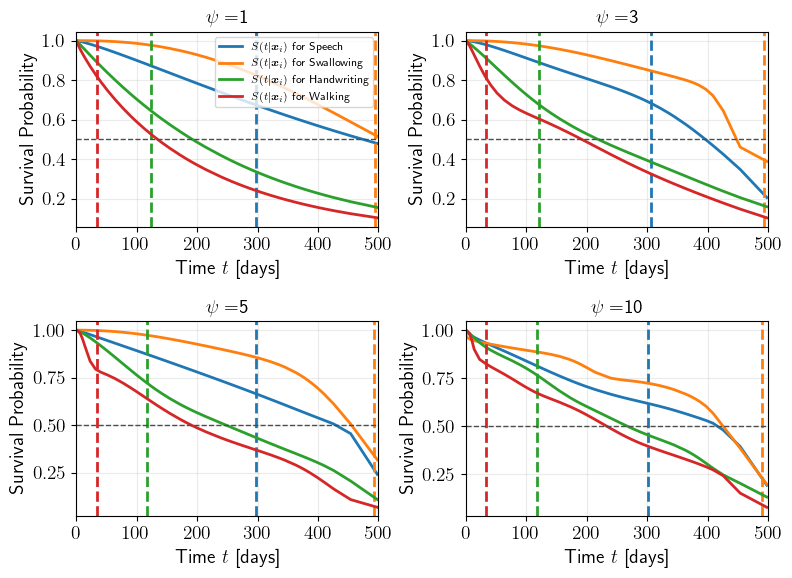

In [6]:
import matplotlib.pyplot as plt

from SurvivalEVAL import LifelinesEvaluator
from SurvivalEVAL.Evaluations.util import predict_median_survival_time

# Configure plot dimensions
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()  # Flatten axes for easy indexing

event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
psi_values = {0: 1, 1: 3, 2: 5, 3:10}

sample_idx = 100
for i, trained_model_pred in enumerate(trained_model_preds):
    ax = axes[i]  # Select the appropriate subplot for this model

    # Add title
    ax.set_title(r"$\psi= $" + f"{psi_values[i]}")

    # Get actual/predicted survival times for each model
    event_pred_outputs = []
    event_sample_tte, event_observed, event_pred_survival_times = [], [], []
    for event_id in range(n_events):
        sample_tte = test_dict['T'][sample_idx, event_id]
        is_observed = (test_dict['E'][sample_idx, event_id] == 1)
        sample_pred_surv_times = trained_model_pred[event_id].iloc[sample_idx].to_numpy()
        lifelines_eval = LifelinesEvaluator(trained_model_pred[event_id].T,
                                            test_dict['T'][event_id],
                                            test_dict['E'][event_id],
                                            train_dict['T'][event_id],
                                            train_dict['E'][event_id])
        median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)
        pred_survival_time = median_survival_time[sample_idx]
        event_pred_outputs.append(sample_pred_surv_times)
        event_sample_tte.append(sample_tte)
        event_observed.append(is_observed)
        event_pred_survival_times.append(pred_survival_time)
    
    # Plot on the specific subplot
    vertical_line_handles = []
    vertical_line_labels = []

    for j, (event_name, mean_output, sample_tte, is_observed) in \
        enumerate(zip(event_names, event_pred_outputs, event_sample_tte, event_observed)):
            
        # Plot the survival curves
        ax.plot(time_bins, mean_output, linewidth=2,
                label=r"$S(t|\bm{x}_{i})$" + f" for {event_name}", color=f"C{j}")
    
        # Plot vertical lines if the event is observed
        if is_observed:
            jitter = np.random.uniform(-5, 5)
            vline = ax.axvline(x=int(sample_tte) + jitter, linestyle="dashed", linewidth=2, color=f"C{j}")
            # Store the vertical line handle and label separately
            vertical_line_handles.append(vline)
    
    # Add a horizontal dashed line at y=0.5
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1, color="#4D4D4D")

    # Axis labels and limits
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Time $t$ [days]")
    ax.set_xlim((0, 500))

    if i == 0: # Add the legend only for the first subplot
        # Get the existing legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # Extend the existing legend with vertical line labels
        handles.extend(vertical_line_handles)
        labels.extend(vertical_line_labels)
        ax.legend(handles, labels, loc="upper right", fontsize=8)

    # Add grid
    ax.grid(True, alpha=0.25)
    
# Adjust layout
plt.tight_layout()

# Save the plot (optional)
plt.savefig(f"{cfg.RESULTS_DIR}/proact_isd_mixtures.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()